## Creating features

In [1]:
import rasterio as rs
from matplotlib import pyplot as plt
import os
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import numpy as np 
from scipy.ndimage import generic_filter
import seaborn as sns


src_folder_path = os.path.abspath('..')
project_folder_path = Path(src_folder_path).resolve().parents[0]

In [2]:
import pandas as pd
data_path = project_folder_path.joinpath(r'data\train.csv')
train_set = pd.read_csv(data_path)
data_test_path = project_folder_path.joinpath(r'data\test.csv')
test_set = pd.read_csv(data_test_path)




Lets create more features

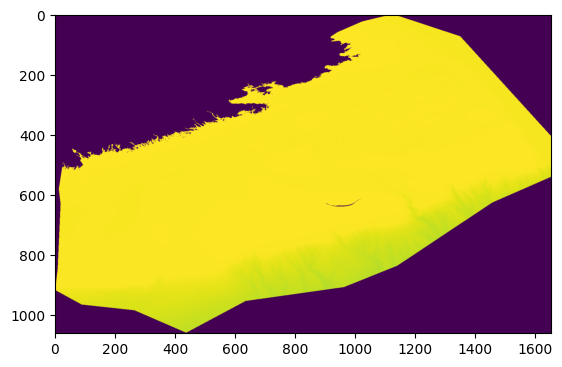

-32768
| 0.00, 0.00,-63.91|
| 0.00,-0.00, 46.59|
| 0.00, 0.00, 1.00|
0.004166666666666668
-0.004166666666666668
CRS: EPSG:4326
Units: unknown
Units: degree


In [3]:
#First, lets import the gebco

from pyproj import CRS
#degrees_to_meters = 111139
gebco = rs.open(project_folder_path.joinpath(r'data\auxiliary_data\gebco.tif'))

depth = gebco.read(1)
transform = gebco.transform
crs = gebco.crs


plt.imshow(depth)
plt.show()
print(np.min(depth))
print(transform)
print(transform[0])
print(transform[4])
print(f"CRS: {crs}")
units = crs.linear_units
print(f"Units: {units}") #Klarer ikke units
# Create a CRS object
crs_proj = CRS.from_wkt(crs.to_wkt())

# Get the units
units = crs_proj.axis_info[0].unit_name
print(f"Units: {units}")




In [4]:
## Slope. We need to function to calculate the size of pixels etc. 

import math
def degrees_to_meters(lat, lon, cell_size_x_deg, cell_size_y_deg):
    # Earth's radius in meters
    R = 6378137
    
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    
    # Calculate the size of a degree in meters at the given latitude
    meters_per_deg_lat = (2 * math.pi * R) / 360
    meters_per_deg_lon = (2 * math.pi * R * math.cos(lat_rad)) / 360
    
    # Convert cell size from degrees to meters
    cell_size_x_meters = cell_size_x_deg * meters_per_deg_lon
    cell_size_y_meters = cell_size_y_deg * meters_per_deg_lat
    
    return cell_size_x_meters, cell_size_y_meters

In [5]:
#Now we can caluclate cell size
cell_size_x, cell_size_y =  degrees_to_meters(transform[2], transform[5], transform[0],  np.abs(transform[4]))
#cell_size_x = transform[0]* degrees_to_meters
#cell_size_y = np.abs(transform[4]* degrees_to_meters)

print(f'Cell_size_x: {cell_size_x}')
print(f'Cell_size_y: {cell_size_y}')

Cell_size_x: 203.9969337425682
Cell_size_y: 463.8312116386401


In [6]:
#Lets calculate slope and aspect
# Function to calculate slope and aspect for non-square cells
def calculate_slope_aspect(dem, cell_size_x, cell_size_y):
    dzdx = (dem[:, 2:] - dem[:, :-2]) / (2 * cell_size_x)
    dzdy = (dem[2:, :] - dem[:-2, :]) / (2 * cell_size_y)
   
    grid_size_y = np.max((dzdx.shape[0],dzdy.shape[0]))
    grid_size_x = np.max((dzdx.shape[1],dzdy.shape[1]))
    #print(grid_size)
    dzdx = np.pad(dzdx, ((0, 0), (1, 1)), mode='edge')
    dzdy = np.pad(dzdy, ((1, 1), (0, 0)), mode='edge')

    slope = np.arctan(np.sqrt(dzdx**2 + dzdy**2)) * (180 / np.pi)
    aspect = np.arctan2(dzdy, -dzdx) * (180 / np.pi)
    aspect = np.where(aspect < 0, 360 + aspect, aspect)

    return slope, aspect


slope, aspect = calculate_slope_aspect(depth, cell_size_x, cell_size_y)


In [7]:
def calculate_terrain_roughness(elevation, window_size=(3,3)):
    # Open the raster file

    # Define a function to calculate the standard deviation within a window
    def roughness_std(window):
        return np.std(window)
    def roughness(window):
        invalid_val = -32768
        temp_window = window[window !=invalid_val ]
        return 0 if len(temp_window)==0 else np.max(temp_window)-np.min(temp_window)
    # Apply the function using a moving window
    roughness_array = generic_filter(elevation, roughness, size=window_size)

   
    return roughness_array
rough = calculate_terrain_roughness(depth, window_size=(3,3))

In [8]:
def bathymetric_position_index(elevation, window_size=(3,3)):
    # Open the raster file

    # Define a function to calculate the standard deviation within a window
    def bpi_function(values):
        invalid_val = -32768
        values = values
        center_value = values[len(values) // 2]
        temp_neighbors = np.delete(values, len(values) // 2)
        temp_neighbors2 = temp_neighbors[temp_neighbors != invalid_val]
        neighbors_mean = 0 if len(temp_neighbors2)==0 else np.mean(temp_neighbors2)
        return center_value - neighbors_mean
    # Apply the function using a moving window
    bpi= generic_filter(elevation, bpi_function, size=window_size)

   
    return bpi
bpi = bathymetric_position_index(depth, window_size=(3,3))

In [9]:
#Convert coordinates to the images coordinate:
from rasterio.transform import rowcol

# Convert coordinates to pixel positions
train_set['y_im'], train_set['x_im'] = zip(*train_set.apply(lambda x: rowcol(transform, x['x'], x['y']), axis=1))
test_set['y_im'], test_set['x_im'] = zip(*test_set.apply(lambda x: rowcol(transform, x['x'], x['y']), axis=1))

#convert x_im and y_im into meters:
test_set['x_m'], test_set['y_m'] = zip(*test_set.apply(lambda x: (x['x_im']*cell_size_x, x['y_im']*cell_size_y), axis=1))
train_set['x_m'], train_set['y_m'] = zip(*train_set.apply(lambda x: ( x['x_im']*cell_size_x, x['y_im']*cell_size_y), axis=1))

In [10]:
print(test_set['y_im'])

0      634
1      606
2      672
3      694
4      660
      ... 
523    578
524    581
525    566
526    590
527    629
Name: y_im, Length: 528, dtype: int32


[[0.60833333 0.6083476  0.60839041 ... 2.69916718 2.70324522 2.70732353]
 [0.60416667 0.60418103 0.60422414 ... 2.6983148  2.70239413 2.70647372]
 [0.6        0.60001447 0.60005787 ... 2.69746859 2.7015492  2.70563006]
 ...
 [2.26251535 2.26226595 2.2620242  ... 4.65494435 4.65733628 4.65973071]
 [2.26667433 2.26642539 2.26618408 ... 4.65835756 4.66074773 4.66314041]
 [2.27083333 2.27058485 2.27034398 ... 4.66177199 4.66416041 4.66655134]]


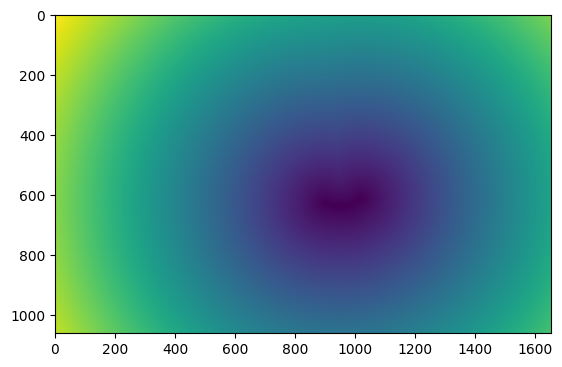

In [16]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
from shapely.geometry import shape
from scipy.spatial import cKDTree
import numpy as np

def calculate_distance_to_land(raster_data, transform, shapefile_path, island_coords = np.array([])):
    # Load the raster data
 

    # Load the shapefile data
    land_shapes = gpd.read_file(shapefile_path)

    # Create a mask for the land area
    land_mask = np.zeros(raster_data.shape, dtype=bool)
    for geom in land_shapes.geometry:
        geom_mask = geometry_mask([geom], transform=transform, invert=True, out_shape=raster_data.shape)
        land_mask |= geom_mask
    if not (island_coords.size==0) :
        land_mask[island_coords[0,0]:island_coords[0,1], island_coords[1,0]:island_coords[1,1]] = False

    # Get the coordinates of all raster cells
    rows, cols = np.indices(raster_data.shape)
    x_coords, y_coords = rasterio.transform.xy(transform, rows, cols)

    # Flatten the coordinates and mask arrays
    x_coords_flat = np.array(x_coords).flatten()
    y_coords_flat = np.array(y_coords).flatten()
    land_mask_flat = land_mask.flatten()

    # Get the coordinates of the land cells
    land_x_coords = x_coords_flat[land_mask_flat]
    land_y_coords = y_coords_flat[land_mask_flat]

    # Create a KDTree for the land cells
    land_tree = cKDTree(np.c_[land_x_coords, land_y_coords])

    # Calculate the distance from each raster cell to the nearest land cell
    distances, _ = land_tree.query(np.c_[x_coords_flat, y_coords_flat])

    # Reshape the distances array to match the raster shape
    distances_reshaped = distances.reshape(raster_data.shape)

    return distances_reshaped

# Example usage
island_coords = np.array([ [550,800], [800, 1100]])
land_coords = np.array([[0,550], [0,1200]])
shapefile_path = project_folder_path.joinpath(r'data\auxiliary_data\land.shp')
distances_to_land = calculate_distance_to_land(depth, transform, shapefile_path, island_coords)
distance_from_island= calculate_distance_to_land(depth, transform, shapefile_path, land_coords)
combined_distance = calculate_distance_to_land(depth, transform, shapefile_path)
# Print or save the distances as needed
print(distances_to_land)
plt.figure
plt.imshow(distance_from_island)
plt.show()


In [17]:
def degrees_to_meters(distances, latitude):
    # Earth's radius in meters
    R = 6371000

    # Convert degrees to radians
    distances_rad = np.radians(distances)

    # Convert radians to meters (assuming small angles)
    distances_meters = R * distances_rad

    return distances_meters


transform[2]
distances_to_land_m = degrees_to_meters(distances_to_land, transform[2])
distance_from_island_m = degrees_to_meters(distance_from_island, transform[2])
combined_distance_m = degrees_to_meters(combined_distance, transform[2])


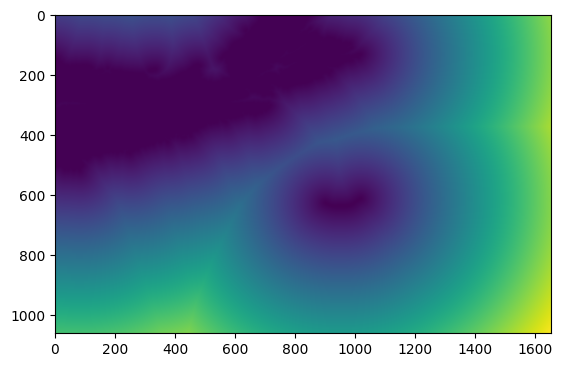

In [32]:
plt.figure
plt.imshow(combined_distance_m)
plt.show()


In [18]:
# Debugging with print statements
def debug_lambda(x):
    print(f"y_im: {x['y_im']}, x_im: {x['x_im']}")
    return rough[int(x['y_im']), int(x['x_im'])]

test_set['rough'] = test_set.apply(debug_lambda, axis=1)

y_im: 634.0, x_im: 803.0
y_im: 606.0, x_im: 772.0
y_im: 672.0, x_im: 1057.0
y_im: 694.0, x_im: 1082.0
y_im: 660.0, x_im: 1139.0
y_im: 725.0, x_im: 834.0
y_im: 730.0, x_im: 840.0
y_im: 601.0, x_im: 663.0
y_im: 595.0, x_im: 663.0
y_im: 429.0, x_im: 991.0
y_im: 361.0, x_im: 1147.0
y_im: 369.0, x_im: 1304.0
y_im: 292.0, x_im: 1327.0
y_im: 294.0, x_im: 1446.0
y_im: 259.0, x_im: 1452.0
y_im: 259.0, x_im: 1396.0
y_im: 272.0, x_im: 1228.0
y_im: 192.0, x_im: 1267.0
y_im: 198.0, x_im: 1207.0
y_im: 494.0, x_im: 894.0
y_im: 260.0, x_im: 914.0
y_im: 757.0, x_im: 366.0
y_im: 687.0, x_im: 565.0
y_im: 604.0, x_im: 719.0
y_im: 645.0, x_im: 917.0
y_im: 714.0, x_im: 817.0
y_im: 657.0, x_im: 790.0
y_im: 892.0, x_im: 620.0
y_im: 878.0, x_im: 670.0
y_im: 871.0, x_im: 728.0
y_im: 903.0, x_im: 699.0
y_im: 847.0, x_im: 708.0
y_im: 821.0, x_im: 819.0
y_im: 780.0, x_im: 933.0
y_im: 792.0, x_im: 913.0
y_im: 755.0, x_im: 921.0
y_im: 790.0, x_im: 956.0
y_im: 790.0, x_im: 956.0
y_im: 752.0, x_im: 966.0
y_im: 758.0, 

In [20]:
train_set['slope'] = train_set.apply(lambda x: slope[int(x['y_im']), int(x['x_im'])], axis=1)
train_set['aspect'] = train_set.apply(lambda x: aspect[int(x['y_im']), int(x['x_im'])], axis=1)

test_set['slope'] = test_set.apply(lambda x: slope[int(x['y_im']), int(x['x_im'])], axis=1)
test_set['aspect'] = test_set.apply(lambda x: aspect[int(x['y_im']), int(x['x_im'])], axis=1)

test_set['rough'] = test_set.apply(lambda x: rough[int(x['y_im']), int(x['x_im'])], axis=1)
train_set['rough'] = train_set.apply(lambda x: rough[int(x['y_im']), int(x['x_im'])], axis=1)

test_set['bpi'] = test_set.apply(lambda x: bpi[int(x['y_im']), int(x['x_im'])], axis=1)
train_set['bpi'] = train_set.apply(lambda x: bpi[int(x['y_im']), int(x['x_im'])], axis=1)

test_set['shore_dist'] = test_set.apply(lambda x: distances_to_land_m[int(x['y_im']), int(x['x_im'])], axis=1)
train_set['shore_dist'] = train_set.apply(lambda x: distances_to_land_m[int(x['y_im']), int(x['x_im'])], axis=1)

test_set['island_dist'] = test_set.apply(lambda x: distance_from_island_m[int(x['y_im']), int(x['x_im'])], axis=1)
train_set['island_dist'] = train_set.apply(lambda x: distance_from_island_m[int(x['y_im']), int(x['x_im'])], axis=1)

test_set['comb_dist'] = test_set.apply(lambda x: combined_distance_m[int(x['y_im']), int(x['x_im'])], axis=1)
train_set['comb_dist'] = train_set.apply(lambda x: combined_distance_m[int(x['y_im']), int(x['x_im'])], axis=1)


In [21]:
#current range instead of max and mean
train_set['current_range'] = train_set['current_max']-train_set['current_min']
test_set['current_range'] = test_set['current_max']-test_set['current_min']

In [22]:
train_set.to_csv('../../data/train_set_with_feat_unclean.csv', index=False)
test_set.to_csv('../../data/test_set_with_feat_unclean.csv', index=False)

Feature rydding

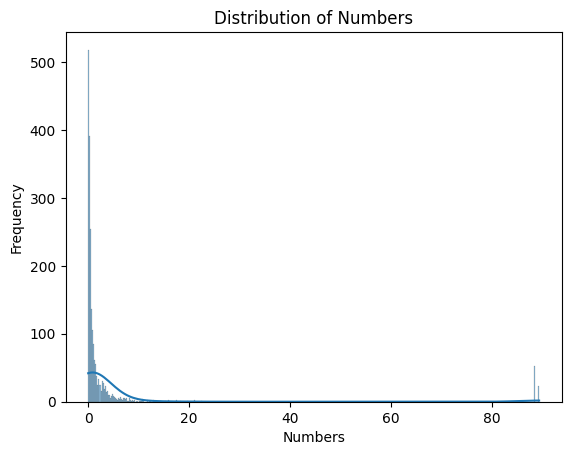

In [23]:

train_set['slope'].describe()
sns.histplot(train_set['slope'], kde=True)
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')
plt.show()

In [24]:
train_set.loc[train_set['slope']>12, 'slope'] = 12
test_set.loc[test_set['slope']>12, 'slope'] = 12

#train_set['slope'][train_set['slope']>12] = 12
#test_set['slope'][test_set['slope']>12] = 12



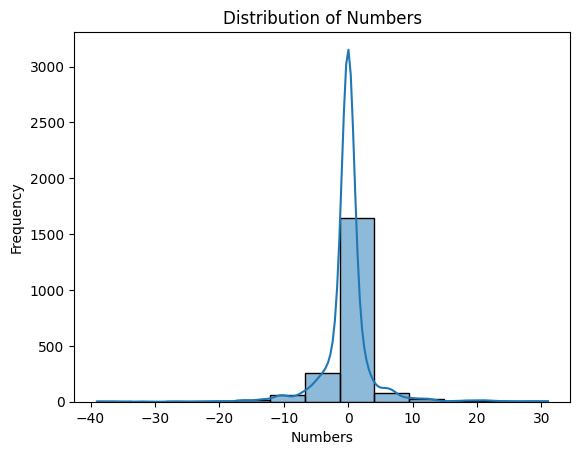

In [25]:

train_set['bpi'].describe()
sns.histplot(train_set['bpi'], kde=True)
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')
plt.show()

In [26]:
bpi_thres = 20
indx_train = np.abs(train_set['bpi'])>bpi_thres
indx_test = np.abs(test_set['bpi'])>bpi_thres

train_set.loc[indx_train,'bpi' ]=  np.sign(train_set.loc[indx_train,'bpi' ])*bpi_thres
test_set.loc[indx_test,'bpi' ]=  np.sign(test_set.loc[indx_test,'bpi' ])*bpi_thres

#['bpi'][np.abs(train_set['bpi'])>12] = np.sign(train_set['bpi'][np.abs(train_set['bpi'])>12])*12
#test_set['bpi'][np.abs(test_set['bpi'])>12] = np.sign(test_set['bpi'][np.abs(test_set['bpi'])>12])*12



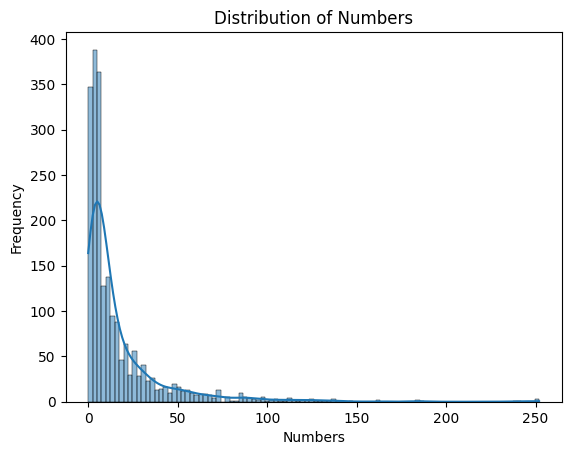

In [27]:
sns.histplot(train_set['rough'], kde=True)
plt.xlabel('Numbers')
plt.ylabel('Frequency')
plt.title('Distribution of Numbers')
plt.show()

In [28]:
rough_thres = 150
train_set.loc[train_set['rough']>rough_thres, 'rough'] = rough_thres
test_set.loc[test_set['rough']>rough_thres, 'rough'] = rough_thres



#train_set['rough'][train_set['rough']>150] = 150
#test_set['rough'][test_set['rough']>150] = 150



In [29]:
train_set.to_csv('../../data/train_set_with_feat_cleanCorr.csv', index=False)
test_set.to_csv('../../data/test_set_with_feat_cleanCorr.csv', index=False)